In [ ]:
#evaluating whether GPT can capture many more dependencies in one layer, ie creating
#a much larger delay embedding (as would be necessary due to noise)
#my hypothesis is they can't do this, because attention is sparse. 
#adding more heads could allow for it, so we'll investigate that too

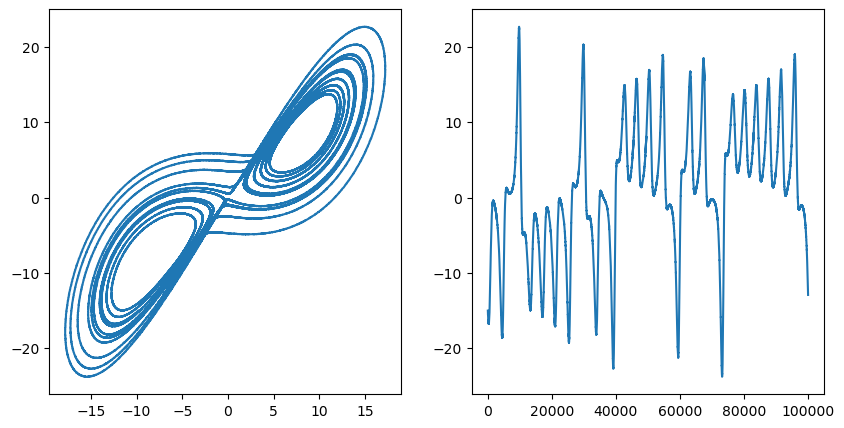

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from utils import embed_signal_torch
import torch

from dysts.flows import Lorenz

## Load and simulate an attractor
model = Lorenz()
# model.dt = 0.01
sol = model.make_trajectory(100000, resample=False, noise=0.0)

sol += np.random.normal(0, 0.01, sol.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(sol[:, 0], sol[:, 1])
ax[1].plot(sol[:, 1])

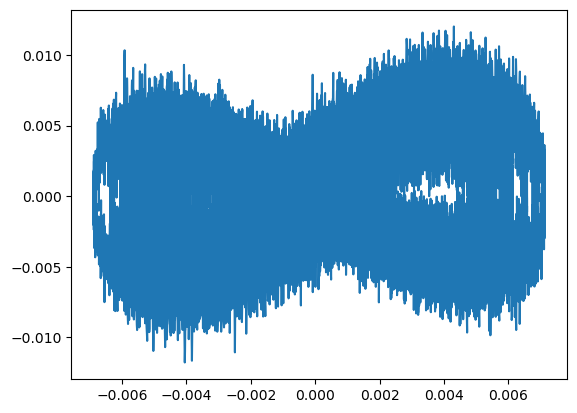

In [6]:

n_delays = 5
delay_interval = 1


H = embed_signal_torch(sol[:, 0:1], n_delays, delay_interval)

U, S, V = torch.svd(H.T)

V = V.cpu().numpy()
plt.plot(V[:, 0], V[:, 1])

In [13]:
import sys

sys.path.append("/om2/user/ostrow/NN_delay_embeddings/nn_delay_embeddings/")
from models import GPT

In [20]:
kwargs = dict(input_dim = 1,
d_model = 10,
n_head = 1,
context_length = 1000,
mlp_hidden=40,
seed=11,
temp=None,
use_pe=False,)
model = GPT(**kwargs)

In [21]:
data = torch.tensor(sol[np.newaxis, :kwargs['context_length'], 0:1]).float()
print(data.size())
out, hidden = model(data)
hidden = hidden.detach().numpy().squeeze()
out.shape, hidden.shape

torch.Size([1, 1000, 1])


(torch.Size([1, 1000, 1]), (1000, 10))

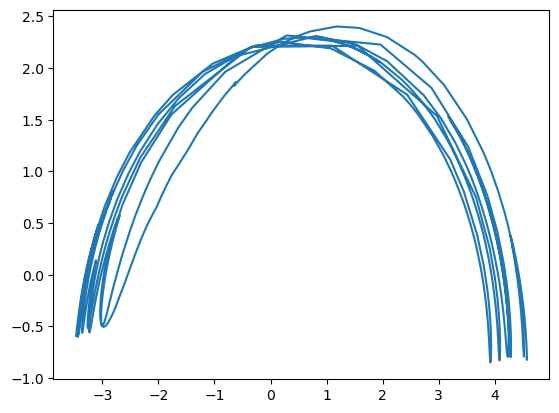

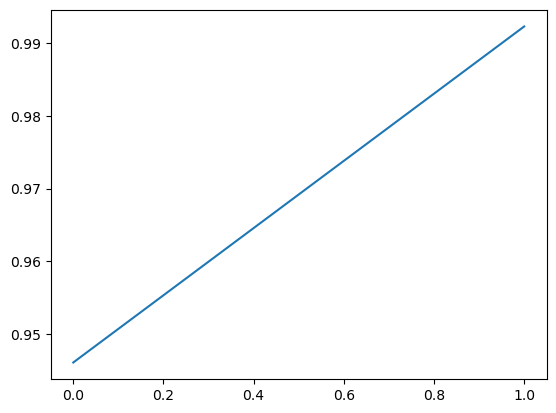

In [22]:
# run pca on the hidden states
from sklearn.decomposition import PCA

hidden = hidden[5:]  # washout the first n

pca = PCA(n_components=2)
pca.fit(hidden)
hidden_pca = pca.transform(hidden)
plt.figure()
plt.plot(hidden_pca[:, 0], hidden_pca[:, 1])
plt.figure()
# plot evr
plt.plot(np.cumsum(pca.explained_variance_ratio_))